### The goal of this project is to create a model that can accurately detect whether a patient has viral or pneumonia, given a chest x-ray (CXR)
- According to the [American Thoracic Society](https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf), pneumonia is the world’s leading cause of death among children under 5 years of age, killing approximately 2,400 children a day. Pnemonia is also the number 1 most common reason for children to be hospitalized in the US. The managment of this disease costs the US over 13 billion USD every year. Although there are adequate treatment (oral and IV antibiotics, IV fluids, oxygen and rehydration therapy), the cause of pneumonia must be identified and treated promptly to prevent the misuse or lack of antibiotics that will cause long term complications and death. 
- The model is to be incorporated into IT softwares (ex: epic) in hospital settings to assist health professionals diagnose the cause of pneumonia so patients can receive the proper treatment plan.

- This deep learning model will be trained and validated using 4,273 pediatric CXR images from the University of California San Diego's image classification dataset: [Kermany Daniel, Zhang Kang, Goldbaum Michael (2018). Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. Mendeley Data, v2, http://dx.doi.org/10.17632/rscbjbr9sj.2](https://data.mendeley.com/datasets/rscbjbr9sj/2)

### Set up notebook

In [32]:
#import libaries
%env PYTHONHASHSEED=0
import numpy as np
from numpy.random import seed
import random as python_random
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(10)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(120)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(123)

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras import backend as K
from keras import models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score

env: PYTHONHASHSEED=0


### Image Preprocessing (rescale, resize, reshape)
- rescale, resize and reshape the images to match the input size of the neural network

In [33]:
#create directory to train and test data
train_folder = '../data/train'
test_folder = '../data/test'

In [34]:
#resize and rescale train and test images
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, 
        target_size=(224, 224), batch_size = 5216)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, 
        target_size=(224, 224), batch_size = 624 ) 

#split data to images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

#reshape train and test images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
#reshape train and test labels
train_y = np.reshape(train_labels[:,0], (3883,1))
test_y = np.reshape(test_labels[:,0], (390,1))

Found 3883 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


### Build model

In [35]:
#create a Sequential model then add layers to it
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(150528,))) 
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Train model

In [36]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives()])

histoire = model.fit(train_img, train_y,
                    epochs=10,
                    batch_size=25,
                    validation_split= 0.1, verbose = 1)

Train on 3494 samples, validate on 389 samples
Epoch 1/10
3494/3494 [==============================] - 6s 2ms/step - loss: 1.2321 - acc: 0.6483 - precision_4: 0.6735 - recall_4: 0.9152 - true_positives_4: 1021.6500 - true_negatives_4: 113.4429 - val_loss: 0.6112 - val_acc: 0.6658 - val_precision_4: 0.6904 - val_recall_4: 0.8445 - val_true_positives_4: 2051.1875 - val_true_negatives_4: 357.1250
Epoch 2/10
3494/3494 [==============================] - 5s 1ms/step - loss: 0.5868 - acc: 0.7026 - precision_4: 0.6990 - recall_4: 0.8465 - true_positives_4: 3114.5215 - true_negatives_4: 629.9000 - val_loss: 0.5968 - val_acc: 0.7198 - val_precision_4: 0.7101 - val_recall_4: 0.8536 - val_true_positives_4: 4239.6250 - val_true_negatives_4: 891.8125
Epoch 3/10
3494/3494 [==============================] - 5s 1ms/step - loss: 0.5828 - acc: 0.7086 - precision_4: 0.7127 - recall_4: 0.8584 - true_positives_4: 5345.3999 - true_negatives_4: 1150.2357 - val_loss: 0.5921 - val_acc: 0.7198 - val_precision_4:

In [27]:
# save model
# model.save('Step02a_model.h5')

### Evaluate validation scores
- val_loss: 0.5738
- val_acc: 0.7275
- val_precision_1: 0.7463 
- val_recall_1: 0.8516
- val_F1: 0.795

The accuracy score of the validation set (10% of train data) is >70%. This model outperforms an average radiologist because, in practice, radiologists cannot predict bacterial vs viral pneumonia on CXR alone. It is also not standard practice for a radiologist to say one vs the other because it is purely a guess. 

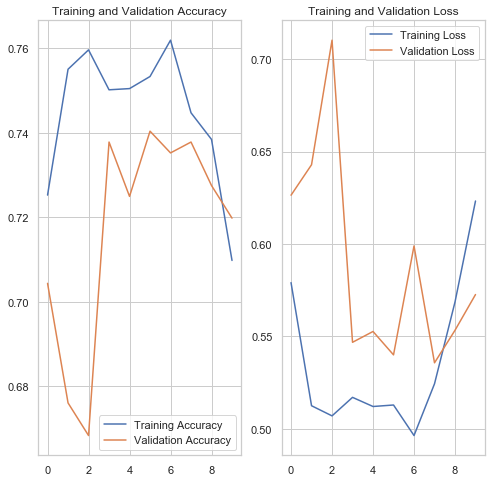

In [25]:
#create a ROC curve to assess accuracy and loss with different epochs
acc = histoire.history['acc']
val_acc = histoire.history['val_acc']

loss = histoire.history['loss']
val_loss = histoire.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test model
- Dense model has the highest accuracy, recall, precision, F1 score 
- To review CNN model, refer to [Step02d](https://github.com/viviandng/capstone1/blob/master/Step02_Training/Step02d_CNN_Model_%20(data_val).ipynb)
- To review Densenet121 model, refer to [Step02e](https://github.com/viviandng/capstone1/blob/master/Step02_Training/Step02e_DenseNet121_model_(data_val).ipynb)
- To review test results on all three models, refer to [Models_and_Results]()

In [37]:
#load model 
dense_model = keras.models.load_model('../models/Step02a_model.h5')

#evaluate with test data
dense_model.evaluate(test_img, test_y)

390/390 [==============================] - 1s 2ms/sample - loss: 0.4613 - acc: 0.8667 - precision_1: 0.8711 - recall_1: 0.9215 - true_positives_1: 223.0000 - true_negatives_1: 115.0000


[0.4613066318707588, 0.8666667, 0.87109375, 0.9214876, 223.0, 115.0]

### Evaluate test scores
- loss: 0.4613 
- acc: 0.8667 
- precision_1: 0.8711 
- recall_1: 0.9215 
- F1: 0.8956

The model performs much better on the test data compared to the validation data above. 

In [39]:
#set up function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[115  33]
 [ 19 223]]


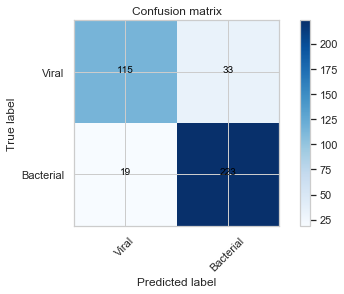

In [40]:
#confusion matrix
y_pred = dense_model.predict_classes(test_img)

cm = confusion_matrix(test_y, y_pred)
classes = ['Viral', 'Bacterial']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')

### Conclusion

In conclusion, the dense model has an accuracy >80%. This means that, for at least 8 out of 10 patients CXR, the model is able to accuractely predict whether these patients have viral or bacterial pneumonia. <br/>
To enhance patient care, the model should be incorporated into IT softwares (ex: epic) in hospital settings to assist health professionals accurately diagnose the cause of pneumonia so patients can receive the proper treatment. <br/>
However, patients may also have fungal pneumonia or superimposed pneumonia where there are multiple pathogens. For further research, collect more pneumonia CXR for different daignoses and create a multi-label image classification model.

### Link to resources
- [American Thoracic Society](https://www.thoracic.org/professionals/career-development/residents-medical-students/ats-reading-list/adult/pneumonia.php)
- [Stanford CheXNet Model](https://stanfordmlgroup.github.io/projects/chexnet/)
- [Udacity TensorFlow Free Course](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187)
- [Keras API](https://keras.io/api/)